
# Stats demo (sample data)


Tests if the evoked response is significantly different between two conditions across subjects.

For demonstration purposes, simulate data from multiple subjects using one subject's data.

In [1]:
import os.path as op
import numpy as np
from scipy import stats as stats
from mayavi import mlab

import mne
from mne.epochs import equalize_epoch_counts
from mne.stats import (spatio_temporal_cluster_1samp_test,
                       summarize_clusters_stc)
from mne.minimum_norm import apply_inverse, read_inverse_operator
from mne.datasets import sample

%matplotlib inline
mlab.options.offscreen = True
mlab.init_notebook('png')

Notebook initialized with png backend.


In [2]:
# Filenames
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
subjects_dir = data_path + '/subjects'
fs_src_fname = subjects_dir + '/fsaverage/bem/fsaverage-ico-5-src.fif'

# Read the raw data and epoch it
raw = mne.io.read_raw_fif(raw_fname)
events = mne.read_events(event_fname)
raw.info['bads'] += ['MEG 2443']
event_id = {'Auditory/Left': 1, 'Visual/Left': 3}
reject = dict(grad=1000e-13, mag=4000e-15, eog=150e-6)
epochs = mne.Epochs(raw, events, event_id,
                    reject=reject, preload=True)
print(epochs)
epochs.equalize_event_counts(list(event_id.keys()))
print(epochs)

<Epochs  |   121 events (all good), -0.199795 - 0.499488 sec, baseline [None, 0], ~40.4 MB, data loaded,
 'Auditory/Left': 55
 'Visual/Left': 66>
<Epochs  |   110 events (all good), -0.199795 - 0.499488 sec, baseline [None, 0], ~37.1 MB, data loaded,
 'Auditory/Left': 55
 'Visual/Left': 55>


In [4]:
# Source localize
fname_inv = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-meg-eeg-inv.fif'
snr = 3.0
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE, sLORETA, or eLORETA)
inv = read_inverse_operator(fname_inv)
print(inv)

<InverseOperator | MEG channels: 305 | EEG channels: 59 | Source space: surface with 7498 sources | Source orientation: Free>


In [5]:
# Average and compute inverse
evoked_aud = epochs['Auditory/Left'].average()
stc_aud = apply_inverse(evoked_aud, inv, lambda2, method)
print(stc_aud)
evoked_vis = epochs['Visual/Left'].average()
stc_vis = apply_inverse(evoked_vis, inv, lambda2, method)
print(stc_vis)

<SourceEstimate  |  7498 vertices, subject : sample, tmin : -199.79521315838787 (ms), tmax : 499.48803289596964 (ms), tstep : 6.659840438612929 (ms), data shape : (7498, 106)>
<SourceEstimate  |  7498 vertices, subject : sample, tmin : -199.79521315838787 (ms), tmax : 499.48803289596964 (ms), tstep : 6.659840438612929 (ms), data shape : (7498, 106)>


## Transform to common cortical space

Normally you would read in estimates across several subjects and morph them to the same cortical space (e.g. fsaverage). **For example purposes**, we will simulate this by just having each "subject" have the same response (just noisy in source space) here.

In [9]:
n_vertices_sample, n_times = stc_aud.data.shape
n_subjects = 7
print('Poorly simulating data for %d subjects...' % n_subjects)

# Let's make sure our results replicate, so set the seed:
rng = np.random.RandomState(0)
X = rng.randn(n_vertices_sample, n_times, n_subjects, 2) * 10
print(X[0, 0, 0])
X[:, :, :, 0] += stc_aud.data[:, :, np.newaxis]
X[:, :, :, 1] += stc_vis.data[:, :, np.newaxis]
print(X.shape)

Poorly simulating data for 7 subjects...
[17.64052346  4.00157208]
(7498, 106, 7, 2)


- Often spatial smoothing is used in group studies
- It is helpful to have data defined on fsaverage
- Smooth and get data on fsaverage using *morphing*

fsaverage use a special icosahedral grade-5 source space with vertices `np.arange(0, 10242)` for each hemisphere.

With real data, you would morph each subject's source data to fsaverage, then combine into one large array `X`.

Here all estimates are on a single subject 'sample' so we can just use one morph matrix for all the heavy lifting.

In [10]:
# Read the source space we a®re morphing to
src = mne.read_source_spaces(fs_src_fname)
fsave_vertices = [s['vertno'] for s in src]
assert np.array_equal(src[0]['vertno'], np.arange(10242))
assert np.array_equal(src[1]['vertno'], np.arange(10242))
print(src)

<SourceSpaces: [<surface (lh), n_vertices=163842, n_used=10242, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=163842, n_used=10242, coordinate_frame=MRI (surface RAS)>]>


In [12]:
morph_mat = mne.compute_source_morph(
    src=inv['src'], subject_to='fsaverage',
    spacing=fsave_vertices, subjects_dir=subjects_dir).morph_mat
print('Morphing matrix shape:')
print(type(morph_mat))
print(morph_mat.shape)
n_vertices_fsave = morph_mat.shape[0]

Morphing matrix shape:
<class 'scipy.sparse.csr.csr_matrix'>
(20484, 7498)


In [13]:
# We have to change the shape for the dot() to work properly
print('Morphing data.')
print(X.shape)
X = X.reshape(n_vertices_sample, n_times * n_subjects * 2)
X = morph_mat.dot(X)  # morph_mat is a sparse matrix
X = X.reshape(n_vertices_fsave, n_times, n_subjects, 2)
print(X.shape)

Morphing data.
(7498, 106, 7, 2)
(20484, 106, 7, 2)


Finally, we want to compare the overall activity levels in each condition, so the diff is taken along the last axis (condition). The negative sign makes it so aud > vis shows up as "red blobs" (instead of blue).



In [14]:
# Prepare for statistical test
X = np.abs(X)  # only magnitude
X = X[:, :, :, 0] - X[:, :, :, 1]  # make paired contrast
print(X.shape)

(20484, 106, 7)



## Do a simple mass-univariate t-test

(20484, 106)



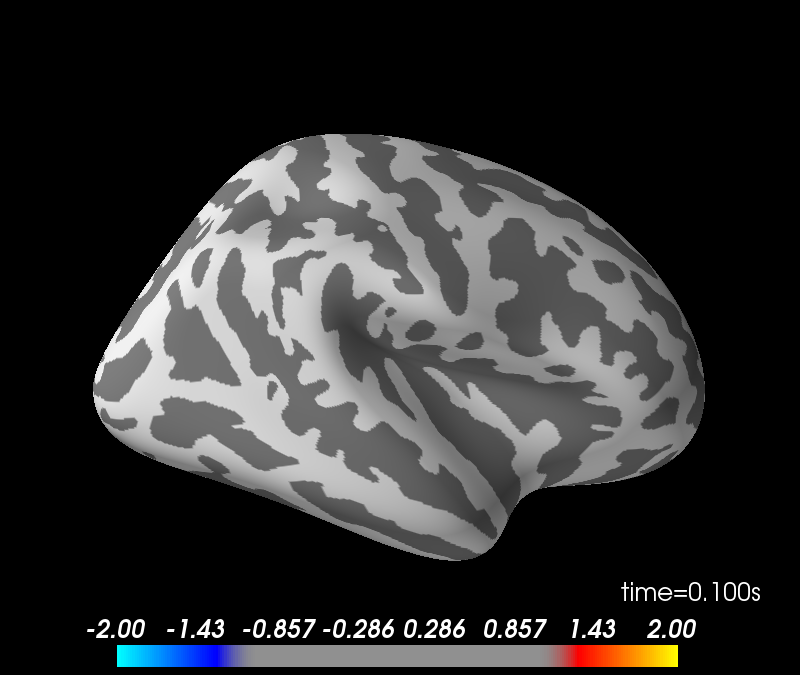

In [18]:
t, p = stats.ttest_1samp(X, 0., axis=-1)  # along "subjects" axis
p = np.minimum(p * n_times * n_vertices_fsave, 1)  # bonferroni
print(p.shape)
p = -np.log10(p) * np.sign(t)
tmin, tstep = stc_aud.tmin, stc_aud.tstep
temp_stc = mne.SourceEstimate(p, fsave_vertices, tmin, tstep, subject='fsaverage')
brain = temp_stc.plot(initial_time=0.1, hemi='rh', clim=dict(kind='value', pos_lims=[1, 1.3, 2]))
brain

## Use clustering correction


In [19]:
print('Computing connectivity for the fsaverage source space.')
connectivity = mne.spatial_src_connectivity(src)
print(connectivity.shape, type(connectivity))

#    Note that X needs to be a multi-dimensional array of shape
#    samples (subjects) x time x space, so we permute dimensions
X = np.transpose(X, [2, 1, 0])
print(X.shape)

Computing connectivity for the fsaverage source space.
(20484, 20484) <class 'scipy.sparse.coo.coo_matrix'>
(7, 106, 20484)


In [20]:
#    Now let's actually do the clustering. This can take a long time...
#    Here we set the threshold quite high to reduce computation.
p_threshold = 0.001
t_threshold = -stats.distributions.t.ppf(p_threshold / 2., n_subjects - 1)
print('Clustering with threshold t=%0.2f' % (t_threshold,))
T_obs, clusters, cluster_p_values, H0 = clu = \
    spatio_temporal_cluster_1samp_test(X, connectivity=connectivity, n_jobs=1,
                                       threshold=t_threshold, buffer_size=None,
                                       verbose=True)

Clustering with threshold t=5.96
stat_fun(H1): min=-24.780884 max=60.429734
Running initial clustering
Found 2066 clusters
Permuting 63 times (exact test)...
[............................................................] 100.00%  |   
Computing cluster p-values
Done.


In [21]:
#    Now select the clusters that are sig. at p < 0.05 (note that this value
#    is multiple-comparisons corrected).
good_cluster_inds = np.where(cluster_p_values < 0.05)[0]
print(len(good_cluster_inds))
print(np.sort(cluster_p_values[good_cluster_inds])[:5])

30
[0.015625 0.015625 0.015625 0.015625 0.015625]


Visualize the clusters
----------------------



Visualizing clusters.



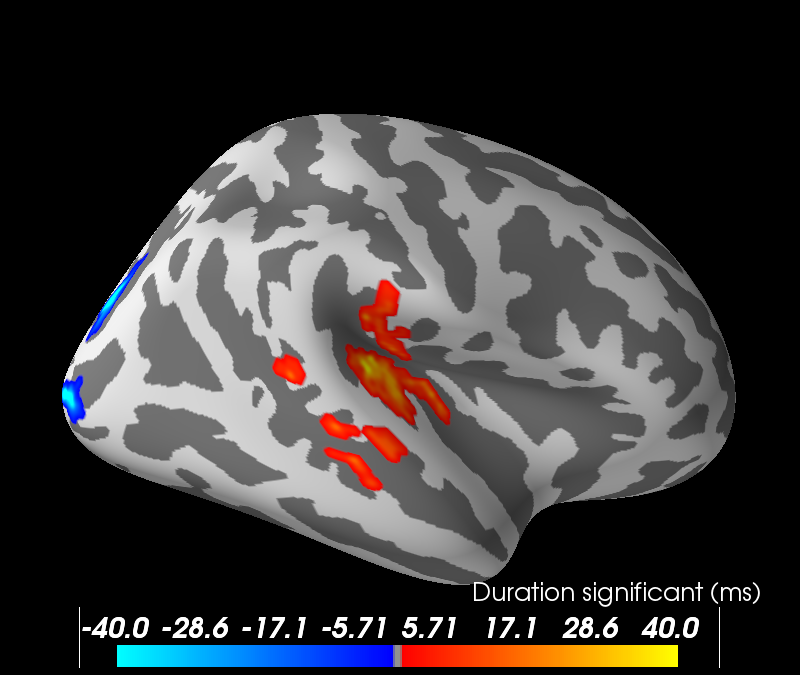

In [22]:
print('Visualizing clusters.')

# Now let's build a convenient representation of each cluster, where each
# cluster becomes a "time point" in the SourceEstimate
stc_all_cluster_vis = summarize_clusters_stc(
    clu, tstep=tstep, vertices=fsave_vertices, subject='fsaverage')

# Plot the first "time point" in the SourceEstimate, which
# shows all the clusters, weighted by duration, with blue blobs
# showing aud < vis, red for vis > aud
brain = stc_all_cluster_vis.plot(
    hemi='both', views='lateral', subjects_dir=subjects_dir,
    time_label='Duration significant (ms)', size=(800, 800),
    smoothing_steps=5, clim=dict(kind='value', pos_lims=[0, 1, 40]))
brain